## Import Libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import numpy as np
from datetime import datetime

# Data Preparation

## Load datasets

In [2]:
# Load all sheets into a dictionary of DataFrames
dfs = pd.read_excel('Accountable_dataset.xlsx', sheet_name=None)

# Load each sheet separately
allMetricsByActiveUser = dfs['allMetricsByActiveUser']
cohorts_ConversionToPaid_DE = dfs['cohorts_ConversionToPaid_DE']

## Inspect the datasets

In [12]:
# Checking unique values in the 'user_id' column
num_unique1 = allMetricsByActiveUser['user_id'].nunique()
num_unique2 = cohorts_ConversionToPaid_DE['user_id'].nunique()
print(f"Number of unique 'user_id' in allMetricsByActiveUser: {num_unique1}")
print(f"Number of unique 'user_id' in cohorts_ConversionToPaid_DE: {num_unique2}")

Number of unique 'user_id' in allMetricsByActiveUser: 40566
Number of unique 'user_id' in cohorts_ConversionToPaid_DE: 50000


In [18]:
# Check for duplicate rows
duplicates_allusers = allMetricsByActiveUser[allMetricsByActiveUser.duplicated(keep=False)]

### Handle duplicate rows

In [19]:
# Remove duplicate rows
allMetrics_2 = allMetricsByActiveUser.drop_duplicates()

# Check if duplicates are removed
num_duplicates_after = allMetrics_2.duplicated().sum()
print(f"Number of duplicate rows after removal: {num_duplicates_after}")

Number of duplicate rows after removal: 0


In [20]:
# Check for duplicate user IDs (ignoring other columns)
num_duplicate_user_ids = allMetrics_2['user_id'].duplicated().sum()
print(f"Number of duplicate user IDs: {num_duplicate_user_ids}")

Number of duplicate user IDs: 9223


In [21]:
# Find all rows with duplicate 'user_id'
duplicate_user_ids = allMetrics_2[allMetrics_2.duplicated(subset=['user_id'], keep=False)]

# Group by 'user_id'
grouped = duplicate_user_ids.groupby('user_id')

# Identify columns with differing values for each duplicate 'user_id'
columns_with_differences = {}

for user_id, group in grouped:
    # Check if there are differences in any columns
    differing_cols = group.nunique().loc[lambda x: x > 1].index.tolist()
    
    if differing_cols:
        columns_with_differences[user_id] = differing_cols

# Display the results
#for user_id, cols in columns_with_differences.items():
    #print(f"User ID: {user_id} - Differing Columns: {cols}")

In [22]:
# Remove duplicates by keeping only the first occurrence of each user_id
allMetrics_cleaned = allMetrics_2.drop_duplicates(subset='user_id', keep='first')

# Verify if duplicates were removed
duplicates_after_removal = allMetrics_cleaned[allMetrics_cleaned.duplicated(subset=['user_id'], keep=False)]
print(f"Number of duplicates after removal: {duplicates_after_removal.shape[0]}")

Number of duplicates after removal: 0


## Join the datasets

In [23]:
# Perform an inner join on user_id
merged_df = pd.merge(cohorts_ConversionToPaid_DE, allMetrics_cleaned, on='user_id', how='inner')

In [24]:
# Check for duplicate rows after joining
duplicates = merged_df[merged_df.duplicated(keep=False)]
num_duplicates = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


### Drop duplicate columns

In [25]:
# Check for duplicate columns
def print_x_y_column_contents(df):
    # Get a list of all columns with _x suffix
    columns_x = [col for col in df.columns if col.endswith('_x')]
    columns_y = [col.replace('_x', '_y') for col in columns_x]
    
    # Print columns with _x and corresponding _y columns and their contents
    for col_x, col_y in zip(columns_x, columns_y):
        if col_y in df.columns:
            print(f"Column _x: {col_x}")
            print(f"Contents of {col_x}:")
            print(df[col_x].head(10))  # Print first few rows
            print("="*40)  # Separator line for readability

            print(f"Column _y: {col_y}")
            print(f"Contents of {col_y}:")
            print(df[col_y].head(10))  # Print first few rows
            print("="*40) 

#print_x_y_column_contents(merged_df)

In [26]:
# Drop the duplicate columns with _y suffix
def drop_y_and_rename_x_columns(df):
    # Get a list of all columns with _y suffix
    columns_y = [col for col in df.columns if col.endswith('_y')]
    
    # Drop the columns with _y suffix
    df_dropped_y = df.drop(columns=columns_y)
    
    # Rename the columns with _x suffix by removing the _x
    df_dropped_y.columns = [col.replace('_x', '') for col in df_dropped_y.columns]
    
    return df_dropped_y

merged_df_cleaned = drop_y_and_rename_x_columns(merged_df)

## Pre-processing

### 1. Convert columns to Boolean

In [27]:
# Convert columns to Boolean in allMetricsByActiveUser
columns_to_convert = [
    'created_AccountableBANKING_account', 
    'hasTheirAccountableIBANOnInvoices', 
    'isVerified_AccountableBANKING',
    'has_VATnumber', 
    'has_Steuernummer', 
    'connected_bank', 
    'created_expense', 
    'created_invoice',
    'created_connector',
    'created_other_revenue',
    'created_quote',
    'probably_not_yet_selfemployed',
    'registered_PEPPOL',
    'first_ai_assistant_message'                         
]

# Loop through the columns and create new boolean columns
for col in columns_to_convert:
    # Check if the column is already a boolean or int type
    if pd.api.types.is_integer_dtype(merged_df_cleaned[col]) or pd.api.types.is_bool_dtype(merged_df_cleaned[col]):
        # Convert to boolean (True=1, False=0)
        merged_df_cleaned[f'{col}_bol'] = merged_df_cleaned[col].astype(bool).astype(int)
    else:
        # Replace 0 with NaN and then convert to boolean (True=non-NaN, False=NaN)
        merged_df_cleaned[f'{col}_bol'] = merged_df_cleaned[col].notna().astype(int)

# Check the first few rows to confirm the changes
#merged_df_cleaned.head()

### 2. Handle missing values

In [14]:
# Check unique values
print(merged_df_cleaned['APC1'].unique())
print(merged_df_cleaned['signup_platform'].unique())

[nan 'accountants_and_tax_advisors' 'animal_workers'
 'artists_and_content_creators' 'business_consultants' 'car_dealers'
 'coaches' 'construction_professionals' 'copywriters' 'designers'
 'drivers_and_courriers' 'e-commerce_professionals' 'engineers'
 'finance_professionals' 'food_workers' 'gardeners'
 'hair_and_beauty_workers' 'hospitality_professionals'
 'interpreters_and_translators' 'it_professionals' 'journalists'
 'maintenance_workers' 'marketing_professionals' 'mechanics'
 'media_producers' 'mental_health_professionals' 'metal_workers'
 'paramedical_workers' 'photographers' 'photovoltaic_system_owners'
 'real_estate_professionals' 'retailers' 'security_professionals'
 'sports_professionals' 'tailors' 'teachers' 'trade_representatives'
 'tradesmen' 'warehousing_and_transport_professionals'
 'agricultural_workers' 'dentists' 'doctors' 'handymen'
 'household_helpers' 'masseur' 'office_support_professionals' 'craftsmen'
 'elderly_care_professionals' 'legal_professionals'
 'event_in

In [15]:
# Fill NaN and 'Not found' with 'Not specified'
merged_df_cleaned['signup_platform'] = merged_df_cleaned['signup_platform'].fillna('Not specified').replace('Not found', 'Not specified')

### 3. Handle datetime columns

In [16]:
# List all columns that are datetime64 type
datetime_columns = merged_df_cleaned.select_dtypes(include=['datetime64[ns]']).columns
datetime_columns

Index(['created', 'startDate', 'created_invoice', 'created_quote',
       'created_expense', 'created_connector', 'created_other_revenue',
       'registered_PEPPOL', 'first_ai_assistant_message',
       'firstSubscriptionDate', 'signup_month', 'created_week',
       'hasTheirAccountableIBANOnInvoices'],
      dtype='object')

In [17]:
# Convert all datetime columns to only contain dates (no time) in the format 'YYYY-MM-DD'
for col in datetime_columns:
    merged_df_cleaned[col] = pd.to_datetime(merged_df_cleaned[col]).dt.date  # Converts to date object

In [18]:
# Convert back to datetime64
for col in datetime_columns:
    merged_df_cleaned[col] = pd.to_datetime(merged_df_cleaned[col])

### 4. Drop duplicate columns

In [19]:
# Drop duplicate columns with different capitalization
column_pairs = [
    ('VATType', 'VATtype'),
    ('accountType', 'accounttype'),
    ('applanguage', 'appLanguage'),
    ('signup_os', 'signup_OS')
]

# Iterate over each pair and drop the column with the unwanted name
for col1, col2 in column_pairs:
    if col1 in merged_df_cleaned.columns and col2 in merged_df_cleaned.columns:
        print(f"Dropping column '{col2}' and keeping '{col1}'")
        # Drop col2 and keep col1
        merged_df_cleaned = merged_df_cleaned.drop(columns=[col2])
    else:
        print(f"One or both columns '{col1}' and '{col2}' are missing in the DataFrame.")

Dropping column 'VATtype' and keeping 'VATType'
Dropping column 'accounttype' and keeping 'accountType'
Dropping column 'appLanguage' and keeping 'applanguage'
Dropping column 'signup_OS' and keeping 'signup_os'


### 5. Clean categorical columns

In [20]:
# 1. Standardize the values in the 'signup_os' column
merged_df_cleaned['signup_os'] = merged_df_cleaned['signup_os'].str.lower()  # Convert to lowercase

# Optionally, replace 'Not specified' and 'other' with 'unknown'
merged_df_cleaned['signup_os'] = merged_df_cleaned['signup_os'].replace(['not specified', 'other'], 'unknown')

# Print unique values after cleaning
print("Unique values in 'signup_os' after cleaning:")
print(merged_df_cleaned['signup_os'].unique())

Unique values in 'signup_os' after cleaning:
['unknown' 'ios' 'android']


In [21]:
# 2. Normalize the 'APC1' column:
merged_df_cleaned['APC1'] = merged_df_cleaned['APC1'].str.lower()  # Convert to lowercase
merged_df_cleaned['APC1'] = merged_df_cleaned['APC1'].str.replace('_', ' ')  # Replace underscores with spaces
merged_df_cleaned['APC1'] = merged_df_cleaned['APC1'].str.strip()  # Remove leading/trailing spaces

# Print unique values in 'APC1' after cleaning
print("Unique values in 'APC1' after general standardization:")
print(merged_df_cleaned['APC1'].unique())

Unique values in 'APC1' after general standardization:
[nan 'accountants and tax advisors' 'animal workers'
 'artists and content creators' 'business consultants' 'car dealers'
 'coaches' 'construction professionals' 'copywriters' 'designers'
 'drivers and courriers' 'e-commerce professionals' 'engineers'
 'finance professionals' 'food workers' 'gardeners'
 'hair and beauty workers' 'hospitality professionals'
 'interpreters and translators' 'it professionals' 'journalists'
 'maintenance workers' 'marketing professionals' 'mechanics'
 'media producers' 'mental health professionals' 'metal workers'
 'paramedical workers' 'photographers' 'photovoltaic system owners'
 'real estate professionals' 'retailers' 'security professionals'
 'sports professionals' 'tailors' 'teachers' 'trade representatives'
 'tradesmen' 'warehousing and transport professionals'
 'agricultural workers' 'dentists' 'doctors' 'handymen'
 'household helpers' 'masseur' 'office support professionals' 'craftsmen'
 'elder

In [22]:
# 3. Categorize Campaigns:
# Replace nulls with string
merged_df_cleaned.loc[merged_df_cleaned['identified_campaign'].isna(), 'identified_campaign'] = 'Unknown Campaign'

# Replace underscores with spaces and convert to lowercase
merged_df_cleaned['identified_campaign_cleaned'] = merged_df_cleaned['identified_campaign'].str.replace('_', ' ').str.lower()

# Define a mapping for known categories
campaign_categories = {
    'sea': 'Search Engine Advertising',
    'ugc': 'User Generated Content',
    'static': 'Static Campaign',
    'appinstall': 'App Installation',
    'retargeting': 'Retargeting',
    'invoicing': 'Invoicing',
    'competition': 'Competition Campaign',
    'reels': 'Reels Campaign',
    'vat': 'VAT Campaign',
    'organic': 'Organic Traffic',
}

# Assign categories based on keywords in the cleaned column
def categorize_campaign(campaign_name):
    for keyword, category in campaign_categories.items():
        if keyword in campaign_name:
            return category
    return 'Other'

# Apply categorization
merged_df_cleaned['campaign_category'] = merged_df_cleaned['identified_campaign_cleaned'].apply(categorize_campaign)

# Check the distribution of categories
campaign_distribution = merged_df_cleaned['campaign_category'].value_counts()
print(campaign_distribution)

campaign_category
Other                        26795
Search Engine Advertising     1820
Static Campaign                193
User Generated Content         159
Reels Campaign                  35
App Installation                21
Invoicing                       14
Competition Campaign             7
VAT Campaign                     6
Retargeting                      1
Organic Traffic                  1
Name: count, dtype: int64


### 6. Identify Converted and Non-Converted users

In [23]:
converted_users = merged_df_cleaned[merged_df_cleaned['firstSubscriptionDate'].notna()]
non_converted_users = merged_df_cleaned[merged_df_cleaned['firstSubscriptionDate'].isna()]

# Count the number of Converted and Non-converted users
converted_count = len(converted_users)
non_converted_count = len(non_converted_users)
total_count = converted_count + non_converted_count

# Calculate percentages
converted_percentage = (converted_count / total_count) * 100
non_converted_percentage = (non_converted_count / total_count) * 100

# Create a DataFrame
comparison_df = pd.DataFrame({
    'User Group': ['Converted', 'Non-Converted'],
    'Count': [converted_count, non_converted_count],
    'Percentage': [converted_percentage, non_converted_percentage]
})
comparison_df['Percentage'] = comparison_df['Percentage'].apply(lambda x: f"{round(x, 2)}%")
comparison_df

,User Group,Count,Percentage
0,Converted,4377,15.07%
1,Non-Converted,24675,84.93%


In [26]:
# Add a new column 'Conversion_Status' based on whether 'firstSubscriptionDate' is present or not
merged_df_cleaned['Conversion_Status'] = np.where(
    merged_df_cleaned['firstSubscriptionDate'].notna(), 'Converted', 'Non-converted'
)

# ** Export the cleaned dataset to csv **

## 1. Main dataset

In [25]:
# 1. Create a copy of the original DataFrame
df_with_conversion_status = merged_df_cleaned.copy()

# 2. Handle missing values for categorical columns
df_with_conversion_status['APC1'] = df_with_conversion_status['APC1'].fillna('Not specified')
df_with_conversion_status['identified_source'] = df_with_conversion_status['identified_source'].fillna('Not specified')
df_with_conversion_status['identified_campaign'] = df_with_conversion_status['identified_campaign'].fillna('Not specified')
df_with_conversion_status['identified_content'] = df_with_conversion_status['identified_content'].fillna('Not specified')

In [449]:
# 3. Handle missing values in datetime columns
## List all columns that are datetime64 type
datetime_columns = df_with_conversion_status.select_dtypes(include=['datetime64[ns]']).columns

## Check for nulls in datetime columns
for column in datetime_columns:
    print(f"Null values in '{column}': {df_with_conversion_status[column].isnull().sum()}")

Null values in 'created': 0
Null values in 'startDate': 27019
Null values in 'created_invoice': 18944
Null values in 'created_quote': 28200
Null values in 'created_expense': 10479
Null values in 'created_connector': 21582
Null values in 'created_other_revenue': 22315
Null values in 'registered_PEPPOL': 28400
Null values in 'first_ai_assistant_message': 26787
Null values in 'firstSubscriptionDate': 24675
Null values in 'signup_month': 0
Null values in 'created_week': 0
Null values in 'hasTheirAccountableIBANOnInvoices': 29022


In [450]:
# Ensure the columns are treated as datetime
for col in datetime_columns:
    df_with_conversion_status[col] = pd.to_datetime(df_with_conversion_status[col], errors='coerce')

# Fill NaT values with a placeholder date
df_with_conversion_status[datetime_columns] = df_with_conversion_status[datetime_columns].fillna(pd.to_datetime('1900-01-01'))

# Format all datetime columns to a consistent format
for col in datetime_columns:
    df_with_conversion_status[col] = df_with_conversion_status[col].dt.strftime('%Y-%m-%d %H:%M:%S')

# Check the result
df_with_conversion_status[datetime_columns].head()

,created,startDate,created_invoice,created_quote,created_expense,created_connector,created_other_revenue,registered_PEPPOL,first_ai_assistant_message,firstSubscriptionDate,signup_month,created_week,hasTheirAccountableIBANOnInvoices
0,2023-06-27 00:00:00,2020-09-11 00:00:00,2024-10-24 00:00:00,1900-01-01 00:00:00,2024-10-24 00:00:00,2024-10-24 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2024-10-24 00:00:00,2023-06-01 00:00:00,2023-06-26 00:00:00,1900-01-01 00:00:00
1,2024-03-18 00:00:00,1900-01-01 00:00:00,2024-06-01 00:00:00,1900-01-01 00:00:00,2024-05-17 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2024-04-08 00:00:00,2024-05-17 00:00:00,2024-03-01 00:00:00,2024-03-18 00:00:00,1900-01-01 00:00:00
2,2024-03-22 00:00:00,1900-01-01 00:00:00,2024-08-13 00:00:00,1900-01-01 00:00:00,2024-03-22 00:00:00,2024-08-20 00:00:00,2024-08-14 00:00:00,1900-01-01 00:00:00,2024-11-14 00:00:00,2024-03-22 00:00:00,2024-03-01 00:00:00,2024-03-18 00:00:00,1900-01-01 00:00:00
3,2020-04-05 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2020-04-05 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2020-04-01 00:00:00,2020-03-30 00:00:00,1900-01-01 00:00:00
4,2021-12-06 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2021-12-06 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,2021-12-01 00:00:00,2021-12-06 00:00:00,1900-01-01 00:00:00


In [451]:
# 5. Handle missing values in region column
df_with_conversion_status['region'] = df_with_conversion_status['region'].fillna("No Info")

In [452]:
# 6. Export the cleaned dataset to CSV
df_with_conversion_status.to_csv('Accountable_cleaned.csv', index=False, date_format='%Y-%m-%d')

print("Dataset cleaned and saved as 'Accountable_cleaned.csv'")

Dataset cleaned and saved as 'Accountable_cleaned.csv'


## 2. Feature Usage Frequency

In [464]:
boolean_columns = [
    'has_VATnumber_bol', 'has_Steuernummer_bol', 'connected_bank_bol',
    'created_expense_bol', 'created_invoice_bol', 'created_other_revenue_bol',
    'created_connector_bol', 'created_quote_bol', 'created_AccountableBANKING_account_bol',
    'hasTheirAccountableIBANOnInvoices_bol', 'isVerified_AccountableBANKING_bol',
    'registered_PEPPOL_bol', 'first_ai_assistant_message_bol'
]

feature_usage_rows = []

# Rename columns
column_renaming_dict = {
    'has_VATnumber_bol': 'Has VAT No.',
    'has_Steuernummer_bol': 'Has Steuernummer',
    'connected_bank_bol': 'Connected Bank',
    'created_expense_bol': 'Created Expense',
    'created_invoice_bol': 'Created Invoice',
    'created_other_revenue_bol': 'Created Other Revenue',
    'created_connector_bol': 'Created Connector',
    'created_quote_bol': 'Created Quote',
    'created_AccountableBANKING_account_bol': 'Created Accountable Bank',
    'hasTheirAccountableIBANOnInvoices_bol': 'Accountable IBAN on Invoices',
    'isVerified_AccountableBANKING_bol': 'Verified Accountable Bank',
    'registered_PEPPOL_bol': 'Registered PEPPOL',
    'first_ai_assistant_message_bol': 'First AI Message'
}

# Loop over each boolean feature column
for column in boolean_columns:
    # Get a readable name for the feature
    readable_name = column_renaming_dict.get(column, column)
    
    # Calculate frequencies
    converted_frequency = df_with_conversion_status[df_with_conversion_status['Conversion_Status'] == 'Converted'][column].sum()
    non_converted_frequency = df_with_conversion_status[df_with_conversion_status['Conversion_Status'] == 'Non-converted'][column].sum()
    total_frequency = converted_frequency + non_converted_frequency
    
    # Create a row (as a DataFrame) with both the frequency and percentage metrics
    row = pd.DataFrame({
        'Feature': [readable_name],
        'Converted': [converted_frequency],
        'Non-converted': [non_converted_frequency],
        'Total Frequency': [total_frequency],
    })
    feature_usage_rows.append(row)

# Concatenate all rows into one DataFrame
feature_usage = pd.concat(feature_usage_rows, ignore_index=True)

# Export the results to a CSV
# feature_usage.to_csv('feature_usage_frequency.csv', index=False)

# Display the result
feature_usage

,Feature,Converted,Non-converted,Total Frequency
0,Has VAT No.,1111,879,1990
1,Has Steuernummer,3576,5230,8806
2,Connected Bank,2620,4901,7521
3,Created Expense,4250,14323,18573
4,Created Invoice,3368,6740,10108
5,Created Other Revenue,1742,4995,6737
6,Created Connector,2604,4866,7470
7,Created Quote,468,384,852
8,Created Accountable Bank,141,33,174
9,Accountable IBAN on Invoices,27,3,30


## 3. First Feature Cohort

In [466]:
features = [
    'created_invoice', 'created_quote', 'created_expense',
    'created_connector', 'created_other_revenue', 
    'registered_PEPPOL', 'first_ai_assistant_message', 
    'hasTheirAccountableIBANOnInvoices'
]

# Make sure all feature columns are datetime type
df_with_conversion_status[features] = df_with_conversion_status[features].apply(pd.to_datetime)

# Create a copy of the dataframe for processing
df_processed = df_with_conversion_status.copy()

# Create a mask to identify placeholder dates
placeholder_date = pd.to_datetime('1900-01-01')
placeholder_masks = {}

for feature in features:
    # Create mask for each feature where True = real date (not placeholder)
    placeholder_masks[feature] = df_processed[feature] != placeholder_date

# Find first real feature used for each user
def get_first_real_feature(row):
    valid_dates = {}
    # Check each feature
    for feature in features:
        # Only consider the feature if it's not the placeholder date
        if row[feature] != placeholder_date:
            valid_dates[feature] = row[feature]
    
    # If user has any valid features, return the earliest one
    if valid_dates:
        return min(valid_dates.items(), key=lambda x: x[1])[0]
    else:
        return None  # No real features used

def get_first_real_feature_date(row):
    valid_dates = {}
    for feature in features:
        if row[feature] != placeholder_date:
            valid_dates[feature] = row[feature]
    
    if valid_dates:
        return min(valid_dates.values())
    else:
        return None  # No real features used

# Apply functions to get first feature and its date
df_processed['first_feature'] = df_processed.apply(get_first_real_feature, axis=1)
df_processed['first_feature_used_date'] = df_processed.apply(get_first_real_feature_date, axis=1)

# Remove rows where no real feature was used
df_with_real_features = df_processed.dropna(subset=['first_feature'])

# Filter by 'Converted' and 'Non-converted' users
converted_df = df_with_real_features[df_with_real_features['Conversion_Status'] == 'Converted']
non_converted_df = df_with_real_features[df_with_real_features['Conversion_Status'] == 'Non-converted']

# Create cohort tables
cohort_table = df_with_real_features.groupby('first_feature')['user_id'].count().reset_index().rename(columns={'user_id': 'Total Users'})
converted_cohort_table = converted_df.groupby('first_feature')['user_id'].count().reset_index().rename(columns={'user_id': 'Converted Users'})
non_converted_cohort_table = non_converted_df.groupby('first_feature')['user_id'].count().reset_index().rename(columns={'user_id': 'Non-converted Users'})

# Merge all tables together
cohort_table = cohort_table.merge(converted_cohort_table[['first_feature', 'Converted Users']], on='first_feature', how='left')
cohort_table = cohort_table.merge(non_converted_cohort_table[['first_feature', 'Non-converted Users']], on='first_feature', how='left')

# Fill NaN values with 0 for cases where no users belong to a group
cohort_table.fillna(0, inplace=True)

# Add conversion rate as percentage
cohort_table['Conversion Rate (%)'] = (cohort_table['Converted Users'] / cohort_table['Total Users'] * 100).round(2)

# Renaming features for better readability
feature_rename_dict = {
    'created_invoice': 'Created Invoice',
    'created_quote': 'Created Quote',
    'created_expense': 'Created Expense',
    'created_connector': 'Created Connector',
    'created_other_revenue': 'Created Other Revenue',
    'registered_PEPPOL': 'PEPPOL Registration',
    'first_ai_assistant_message': 'First AI Assistant Message',
    'hasTheirAccountableIBANOnInvoices': 'Accountable IBAN on Invoices'
}

cohort_table['first_feature'] = cohort_table['first_feature'].map(feature_rename_dict)

# Add a row for users with no real features (if you want to track them)
users_with_no_features = len(df_processed) - len(df_with_real_features)
if users_with_no_features > 0:
    no_feature_row = pd.DataFrame({
        'first_feature': ['No Feature Used'],
        'Total Users': [users_with_no_features],
        'Converted Users': [0],  # Assuming these users didn't convert, adjust if needed
        'Non-converted Users': [users_with_no_features],
        'Conversion Rate (%)': [0.0]
    })
    cohort_table = pd.concat([cohort_table, no_feature_row], ignore_index=True)

# Sort by Total Users in descending order
cohort_table = cohort_table.sort_values('Total Users', ascending=False).reset_index(drop=True)

# Print a summary of what was done
print(f"Total users in dataset: {len(df_processed)}")
print(f"Users with at least one real feature: {len(df_with_real_features)}")
print(f"Users with no real features: {users_with_no_features}")

# Export the results to a CSV
cohort_table.to_csv('first_feature_cohort.csv', index=False)

# Print the cohort table
cohort_table

Total users in dataset: 29052
Users with at least one real feature: 27772
Users with no real features: 1280


,first_feature,Total Users,Converted Users,Non-converted Users,Conversion Rate (%)
0,Created Expense,13709,1969,11740,14.36
1,Created Invoice,7746,1682,6064,21.71
2,Created Connector,3029,502,2527,16.57
3,Created Other Revenue,2791,97,2694,3.48
4,No Feature Used,1280,0,1280,0.00
5,Created Quote,311,36,275,11.58
6,First AI Assistant Message,135,54,81,40.00
7,PEPPOL Registration,51,8,43,15.69


#  📉 Exploratory Data Analysis 📉

### Conversion Status Distribution

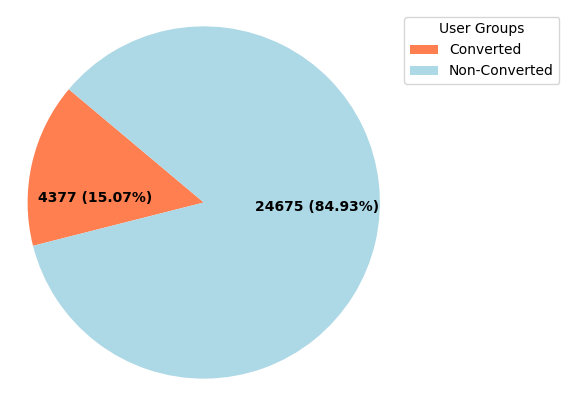

In [28]:
# Create labels for the pie chart
labels = ['Converted', 'Non-Converted']
sizes = [converted_count, non_converted_count]
percentages = [converted_percentage, non_converted_percentage]

# Create data labels with counts and percentages
data_labels = [f'{sizes[i]} ({percentages[i]:.2f}%)' for i in range(len(labels))]

# Colors for the pie chart
colors = ['coral', 'lightblue']

# Create the pie chart
plt.figure(figsize=(5, 5))
wedges, texts = plt.pie(sizes, colors=colors, startangle=140)  

plt.axis('equal') 
plt.legend(wedges, labels, title="User Groups", loc="upper left", bbox_to_anchor=(1, 1))

# Add the data labels
plt.setp(texts, size=10, weight="bold", color='black')
plt.setp(texts, ha='center', va='center')
plt.setp(texts, rotation_mode='anchor')

for text, label, wedge in zip(texts, data_labels, wedges):
    ang = (wedge.theta1 + wedge.theta2) / 2.
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    verticalalignment = {-1: "bottom", 1: "top"}[int(np.sign(y))]
    distance = 0.3 
    text.set_position((x * distance, y * distance))
    text.set_text(label)
    text.set_horizontalalignment(horizontalalignment)
    text.set_verticalalignment(verticalalignment)

plt.show()

### Correlation Matrix

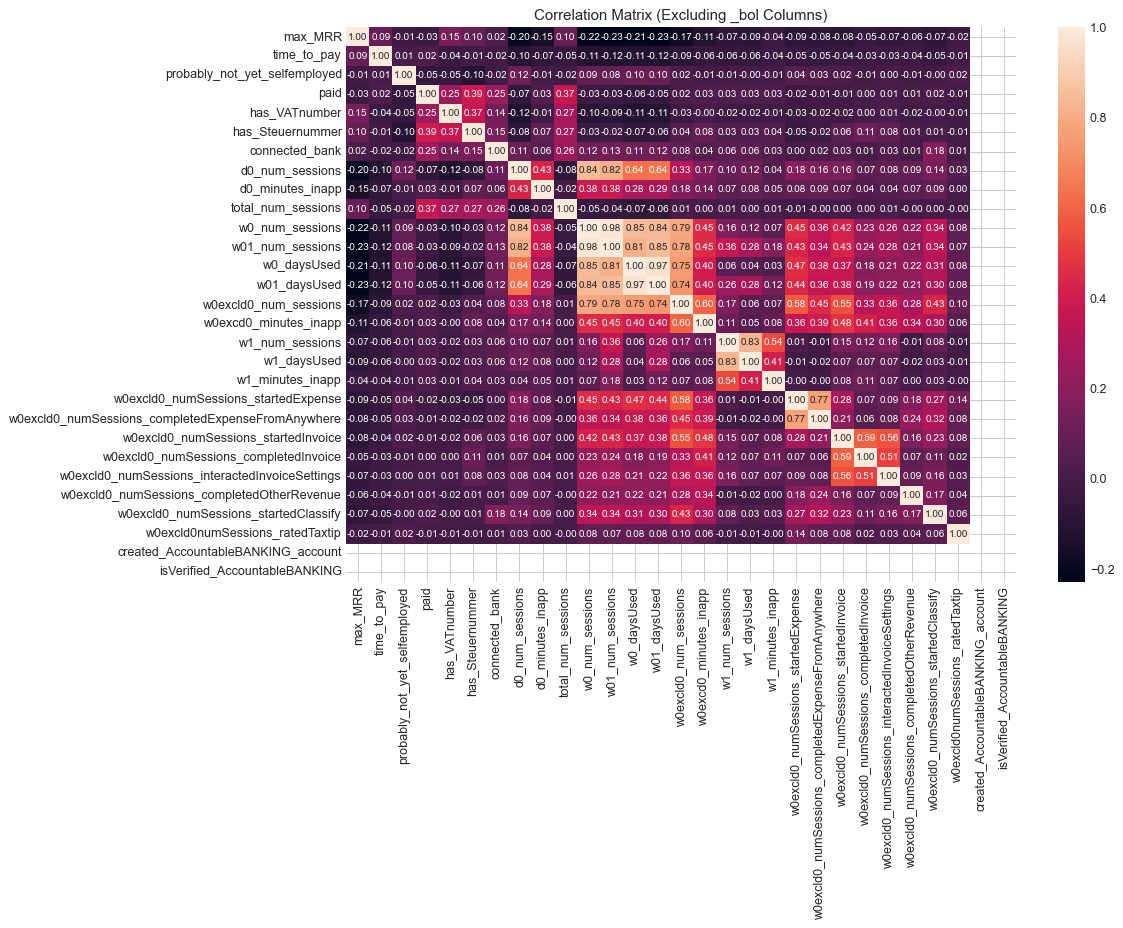

In [280]:
# Filter out columns ending with '_bol'
filtered_df = merged_df_cleaned.loc[:, ~merged_df_cleaned.columns.str.endswith('_bol')]

# Select only numerical columns for correlation matrix
numerical_df = filtered_df.select_dtypes(include=['float64', 'int64'])

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='rocket', fmt=".2f", annot_kws={"size": 8})
plt.title("Correlation Matrix (Excluding _bol Columns)")
plt.show()

### Histograms

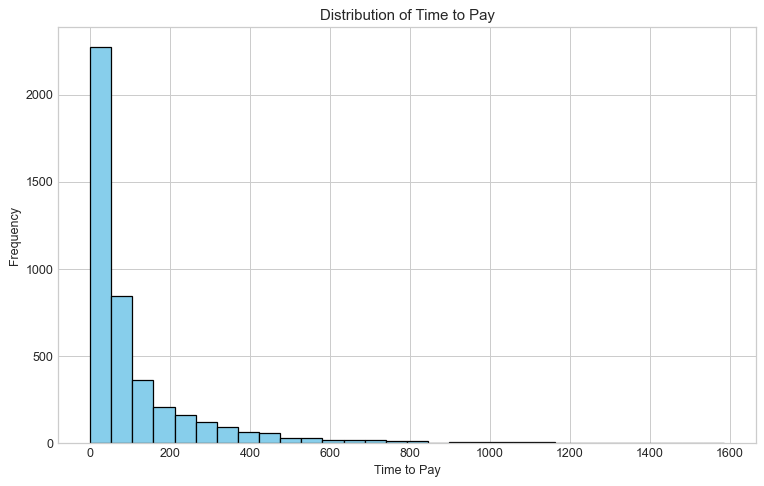

In [283]:
import matplotlib.pyplot as plt

# Plotting the histogram for 'time_to_pay' column
plt.figure(figsize=(10, 6))
plt.hist(merged_df_cleaned['time_to_pay'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Time to Pay')
plt.xlabel('Time to Pay')
plt.ylabel('Frequency')
plt.show()

# 📊 User Behaviour Analysis 📊

## Monthly New Subscribers

<Figure size 1400x600 with 0 Axes>

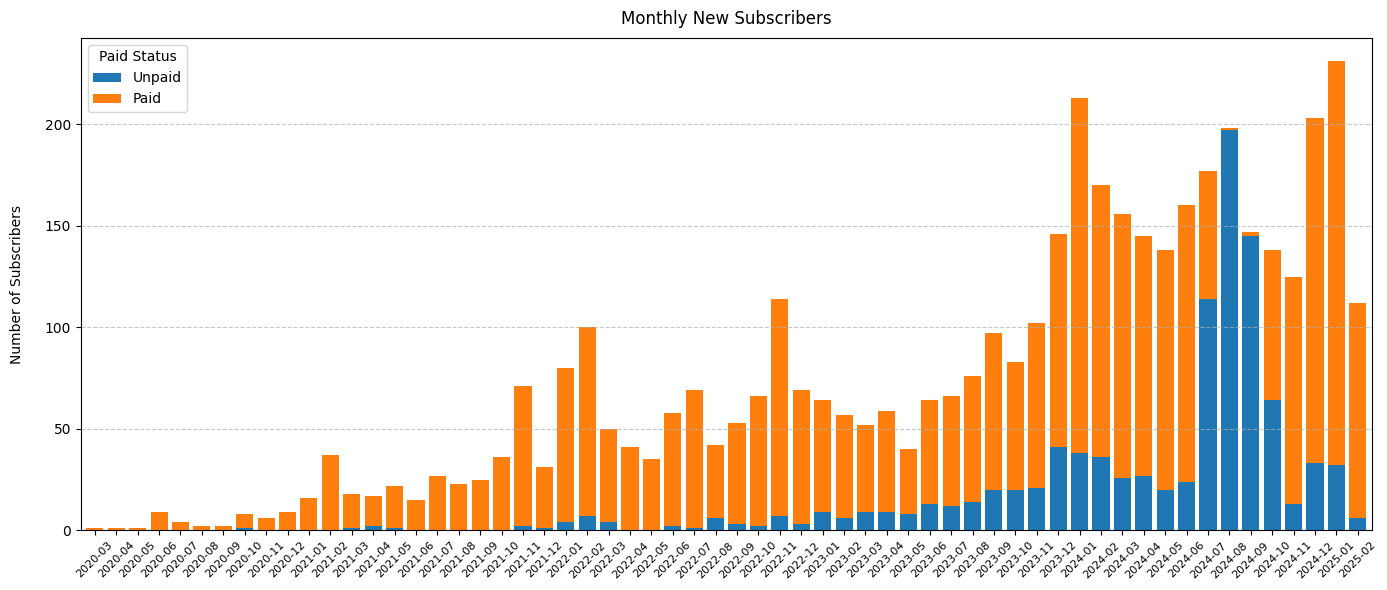

In [32]:
# Ensure datetime format
merged_df_cleaned['firstSubscriptionDate'] = pd.to_datetime(merged_df_cleaned['firstSubscriptionDate'])

# Extract Year-Month period
merged_df_cleaned['YearMonth'] = merged_df_cleaned['firstSubscriptionDate'].dt.to_period('M')

# Group by YearMonth and paid status
monthly_paid_status = merged_df_cleaned.groupby(['YearMonth', 'paid'])['user_id'].nunique().unstack(fill_value=0)

# Convert YearMonth back to string for plotting
monthly_paid_status.index = monthly_paid_status.index.astype(str)

# Plot stacked bar chart
plt.figure(figsize=(14, 6))
monthly_paid_status.plot(kind='bar', stacked=True, figsize=(14, 6), width=0.8)

plt.title('Monthly New Subscribers', pad = 10)
plt.xlabel('')
plt.ylabel('Number of Subscribers', labelpad = 15)
plt.xticks(rotation=45, fontsize=8)
plt.legend(title='Paid Status', labels=['Unpaid', 'Paid'])
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Engagement Metrics

### 1. Summary

In [191]:
# Total Sessions per User
average_sessions = merged_df_cleaned['total_num_sessions'].mean()

# Average Session Duration (time spent per session)
merged_df_cleaned['average_session_duration'] = merged_df_cleaned['w1_minutes_inapp'] / merged_df_cleaned['total_num_sessions']
average_session_duration = merged_df_cleaned['average_session_duration'].mean()

# Feature Usage Rate (Invoice, Expense, etc.)
invoice_usage_rate = merged_df_cleaned['created_invoice_bol'].mean() * 100
expense_usage_rate = (merged_df_cleaned['created_expense_bol'] > 0).mean() * 100

# Days Active in the First Week (Retention Metric)
average_days_active = merged_df_cleaned['w01_daysUsed'].mean()

#  Banking Integration Rate
banking_integration_rate = merged_df_cleaned['connected_bank_bol'].mean() * 100

# Conversion Rate
conversion_rate = (converted_count / len(merged_df_cleaned)) * 100

# Print all results
print(f"Average Total Sessions per User: {average_sessions:.2f}")
print(f"Average Session Duration per User: {average_session_duration:.2f} minutes")
print(f"Invoice Usage Rate: {invoice_usage_rate:.2f}%")
print(f"Expense Usage Rate: {expense_usage_rate:.2f}%")
print(f"Average Days Active in First Week: {average_days_active:.2f}")
print(f"Banking Integration Rate: {banking_integration_rate:.2f}%")
print(f"Conversion Rate: {conversion_rate:.2f}%")

Average Total Sessions per User: 19.10
Average Session Duration per User: 0.05 minutes
Invoice Usage Rate: 34.79%
Expense Usage Rate: 63.93%
Average Days Active in First Week: 1.03
Banking Integration Rate: 25.89%
Conversion Rate: 15.07%


### 2. Comparison of Engagement Metrics between Converted and Non-converted Users

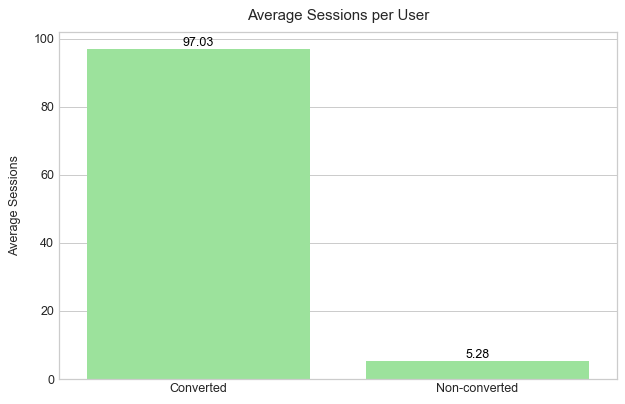

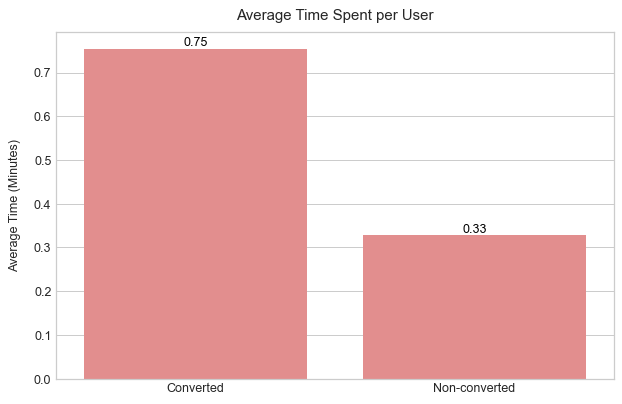

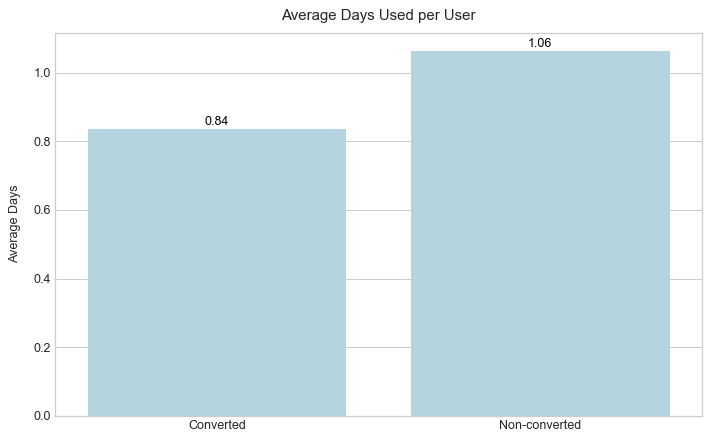

In [192]:
# Average sessions per user
avg_sessions_data = pd.DataFrame({
    'user_group': ['Converted', 'Non-converted'],
    'avg_sessions': [
        converted_users['total_num_sessions'].mean(),
        non_converted_users['total_num_sessions'].mean()
    ]
})

# Average time spent per user
avg_time_spent_data = pd.DataFrame({
    'user_group': ['Converted', 'Non-converted'],
    'avg_time_spent': [
        converted_users['w1_minutes_inapp'].mean(),
        non_converted_users['w1_minutes_inapp'].mean()
    ]
})

# Average days used per user
avg_days_used_data = pd.DataFrame({
    'user_group': ['Converted', 'Non-converted'],
    'avg_days_used': [
        converted_users['w01_daysUsed'].mean(),
        non_converted_users['w01_daysUsed'].mean()
    ]
})

# Consistent size for each plot
plot_size = (8, 5)

# Create individual plots (no columns)
fig1, ax1 = plt.subplots(figsize=plot_size)
sns.barplot(x='user_group', y='avg_sessions', color='lightgreen', data=avg_sessions_data, ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():,.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')
ax1.set_title('Average Sessions per User', pad=10)
ax1.set_ylabel('Average Sessions', labelpad=10)
ax1.set_xlabel('')

fig2, ax2 = plt.subplots(figsize=plot_size)
sns.barplot(x='user_group', y='avg_time_spent', color='lightcoral', data=avg_time_spent_data, ax=ax2)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():,.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')
ax2.set_title('Average Time Spent per User', pad=10)
ax2.set_ylabel('Average Time (Minutes)', labelpad=10)
ax2.set_xlabel('')

fig3, ax3 = plt.subplots(figsize=plot_size)
sns.barplot(x='user_group', y='avg_days_used', color='lightblue', data=avg_days_used_data, ax=ax3)
for p in ax3.patches:
    ax3.annotate(f'{p.get_height():,.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')
ax3.set_title('Average Days Used per User', pad=10)
ax3.set_ylabel('Average Days', labelpad=10)
ax3.set_xlabel('')

# Tight layout for individual plots
plt.tight_layout(h_pad=5, w_pad=3)
plt.show()

## Boolean features comparison between Converted and Non-converted users

### 1. Feature Engagement Rate

<Figure size 1080x1440 with 0 Axes>

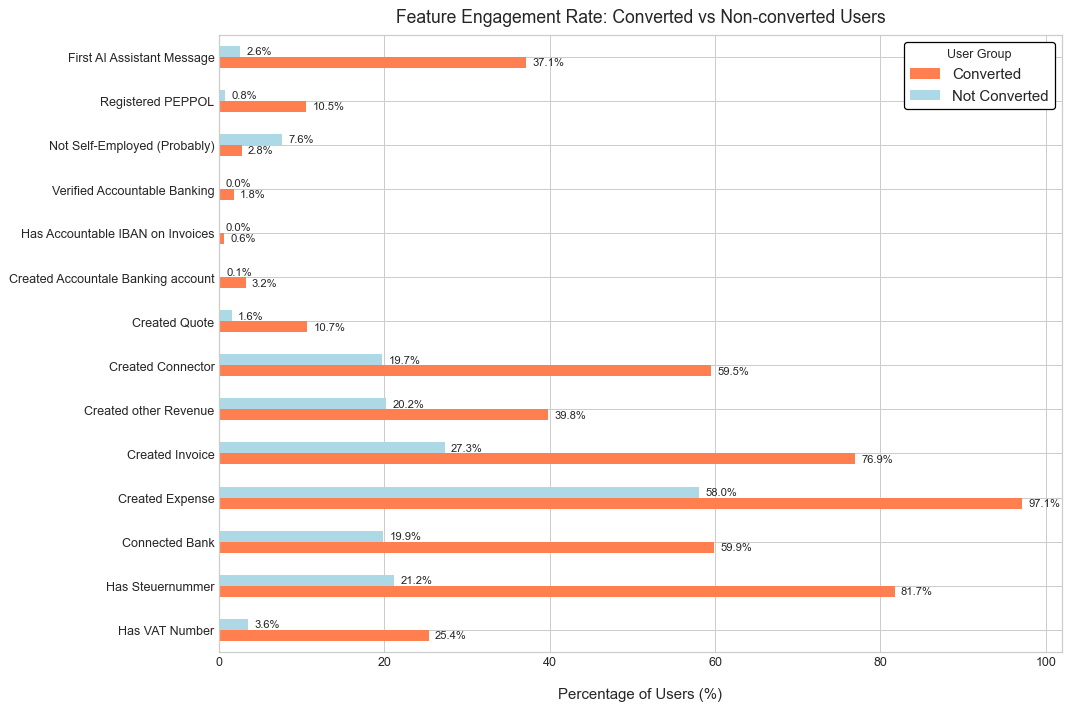

In [270]:
boolean_features = [
    'has_VATnumber_bol', 'has_Steuernummer_bol', 'connected_bank_bol', 
    'created_expense_bol', 'created_invoice_bol', 'created_other_revenue_bol',
    'created_connector_bol', 'created_quote_bol', 'created_AccountableBANKING_account_bol', 
    'hasTheirAccountableIBANOnInvoices_bol', 
    'isVerified_AccountableBANKING_bol',
    'probably_not_yet_selfemployed_bol',
    'registered_PEPPOL_bol',
    'first_ai_assistant_message_bol'
]

# Calculate percentage of users with each feature
converted_percentages = converted_users[boolean_features].mean() * 100
non_converted_percentages = non_converted_users[boolean_features].mean() * 100

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Converted': converted_percentages,
    'Not Converted': non_converted_percentages
})

# Rename the index for better readability
better_names = {
    'has_VATnumber_bol': 'Has VAT Number',
    'has_Steuernummer_bol': 'Has Steuernummer',
    'connected_bank_bol': 'Connected Bank',
    'created_expense_bol': 'Created Expense',
    'created_invoice_bol': 'Created Invoice',
    'created_other_revenue_bol': 'Created other Revenue',
    'created_connector_bol': 'Created Connector',
    'created_quote_bol': 'Created Quote',
    'created_AccountableBANKING_account_bol': "Created Accountale Banking account", 
    'hasTheirAccountableIBANOnInvoices_bol': "Has Accountable IBAN on Invoices", 
    'isVerified_AccountableBANKING_bol': "Verified Accountable Banking",
    'probably_not_yet_selfemployed_bol': "Not Self-Employed (Probably)",
    'registered_PEPPOL_bol': "Registered PEPPOL",
    'first_ai_assistant_message_bol': "First AI Assistant Message"
}
comparison_df.index = [better_names[col] for col in comparison_df.index]

# Plot the boolean feature comparison chart
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 90

plt.figure(figsize=(12, 16))
colors = ['coral', 'lightblue']
ax = comparison_df.plot(kind='barh', color=colors)

# Add data labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v:.1f}%' for v in container.datavalues], padding=5, fontsize=9)

# Title and labels
plt.title('Feature Engagement Rate: Converted vs Non-converted Users', fontsize=14, pad=10)
plt.xlabel('Percentage of Users (%)', fontsize=12, labelpad=15)
plt.ylabel('', fontsize=12)
plt.legend(title='User Group', frameon=True, facecolor='white', edgecolor='black', fontsize=12, framealpha=1)
plt.tight_layout()

plt.show()

### 2. Feature Adoption Over Time

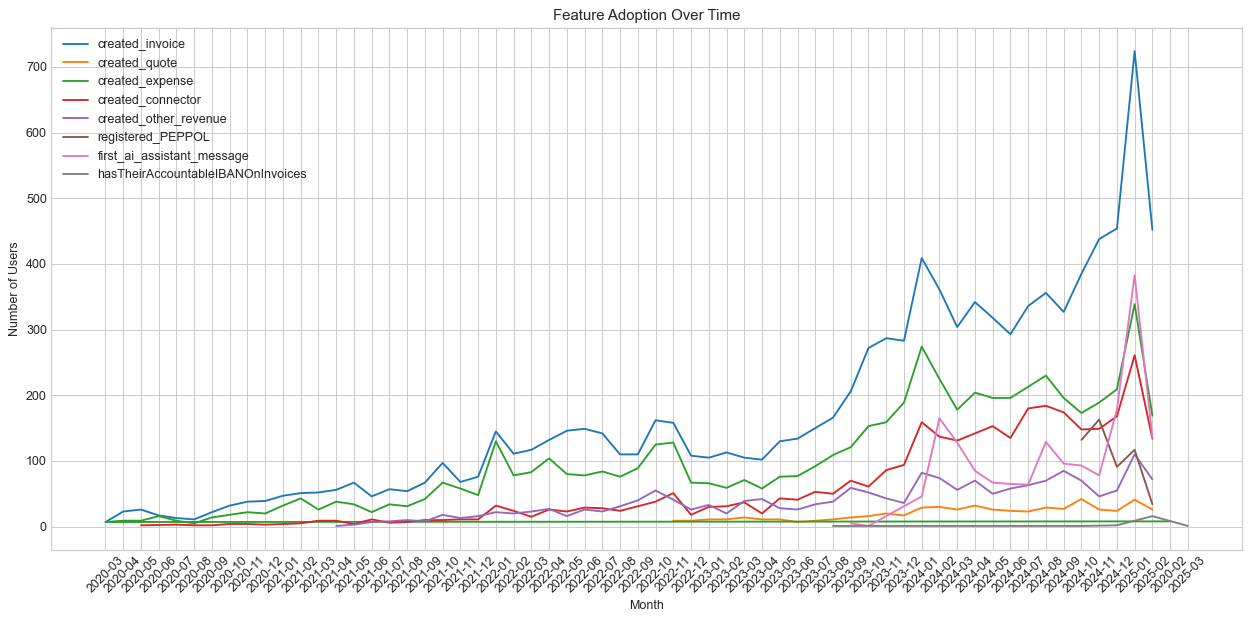

In [360]:
features = [
    'created_invoice', 'created_quote', 'created_expense',
    'created_connector', 'created_other_revenue', 
    'registered_PEPPOL', 'first_ai_assistant_message', 
    'hasTheirAccountableIBANOnInvoices'
]

df_copy = merged_df_cleaned.copy()

plt.figure(figsize=(14, 7))

for feature in features:
    df_copy[feature] = pd.to_datetime(df_copy[feature])
    monthly = df_copy[feature].dropna().dt.to_period('M').value_counts().sort_index()
    monthly.index = monthly.index.astype(str)
    plt.plot(monthly.index, monthly.values, label=feature)

plt.xticks(rotation=45)
plt.title('Feature Adoption Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.legend()
plt.tight_layout()
plt.show()

### 3. Time to Adopt Features After Signup

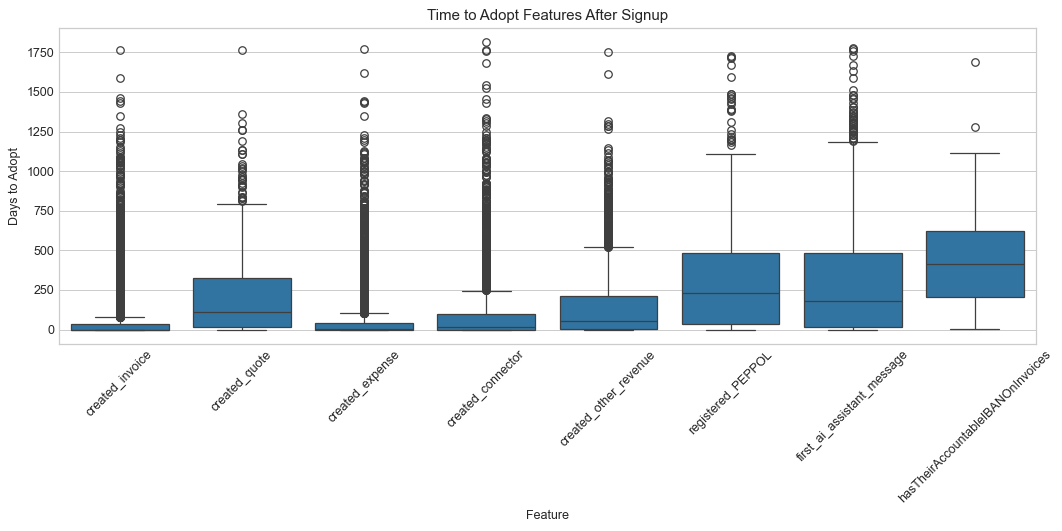

In [361]:
df_copy['created'] = pd.to_datetime(df_copy['created'])

time_diffs = []

for feature in features:
    df_copy[feature] = pd.to_datetime(df_copy[feature])
    df_copy[f'{feature}_diff'] = (df_copy[feature] - df_copy['created']).dt.days
    diffs = df_copy[f'{feature}_diff'].dropna()
    for val in diffs:
        time_diffs.append({'Feature': feature, 'Days to Adopt': val})

df_adoption = pd.DataFrame(time_diffs)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_adoption, x='Feature', y='Days to Adopt')
plt.xticks(rotation=45)
plt.title('Time to Adopt Features After Signup')
plt.tight_layout()
plt.show()

## Profession by Converted and Non-converted users

In [194]:
apc1_counts = pd.DataFrame({
    'Converted': converted_users['APC1'].value_counts(),
    'Non-converted': non_converted_users['APC1'].value_counts()
}).fillna(0)

# Replace underscores with spaces in the index
apc1_counts.index = apc1_counts.index.str.replace('_', ' ')

# Create a table with counts for each profession and sort it by the number of converted users
apc1_table = pd.DataFrame({
    'Converted Users': apc1_counts['Converted'].astype(int),
    'Non-Converted Users': apc1_counts['Non-converted'].astype(int),
})

apc1_table_sorted = apc1_table.sort_values(by='Converted Users', ascending=False)
apc1_table_sorted

,Converted Users,Non-Converted Users
APC1,,
artists and content creators,467,2004
designers,315,1144
it professionals,305,1116
business consultants,197,965
coaches,164,762
photographers,122,433
e-commerce professionals,122,478
marketing professionals,121,378
teachers,96,516


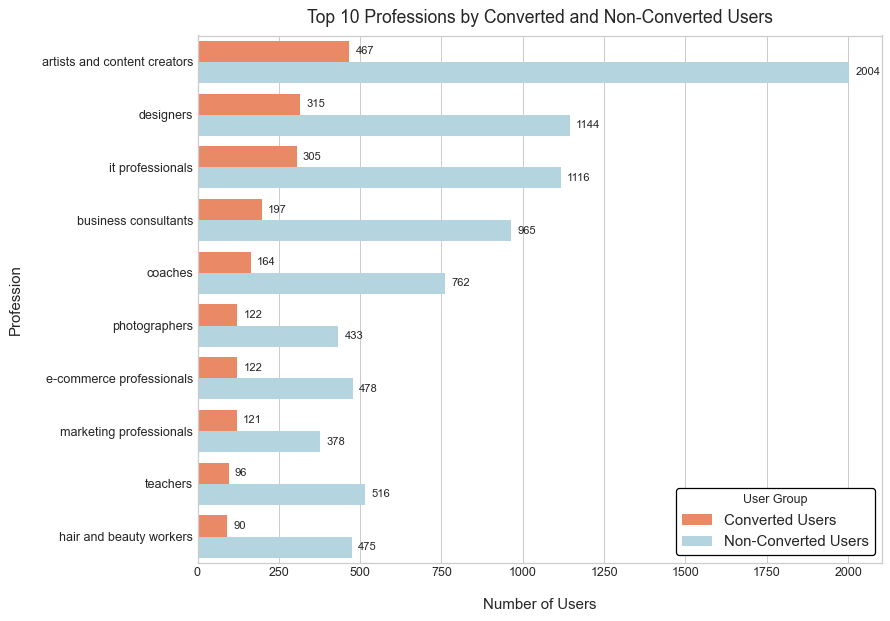

In [195]:
# Sort the table by 'Converted Users' and take the top n professions
top_apc1 = apc1_table_sorted.head(10)

# Create a new DataFrame for plotting
top_apc1_melted = top_apc1.reset_index().melt(id_vars='APC1', value_vars=['Converted Users', 'Non-Converted Users'],
                                                    var_name='User Group', value_name='Count')

# Create bar chart
plt.figure(figsize=(10, 7))
ax = sns.barplot(x='Count', y='APC1', hue='User Group', data=top_apc1_melted, palette=['coral', 'lightblue'])

plt.title('Top 10 Professions by Converted and Non-Converted Users', fontsize=14, pad=10)
plt.xlabel('Number of Users', fontsize=12, labelpad=15)
plt.ylabel('Profession', fontsize=12, labelpad=15)
plt.legend(title='User Group', frameon=True, facecolor='white', edgecolor='black', fontsize=12, framealpha=1)

# Add data labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v)}' for v in container.datavalues], padding=5, fontsize=9)

plt.tight_layout()
plt.show()

## VAT type by Converted and Non-converted users

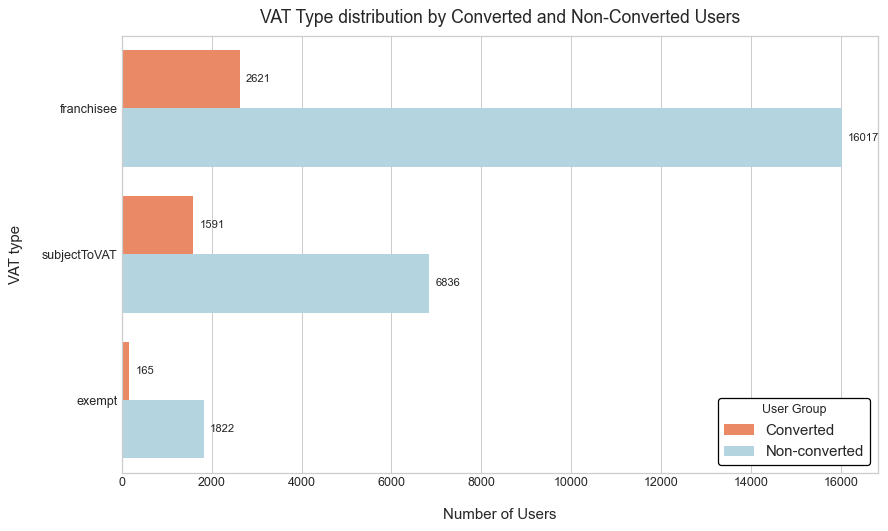

In [105]:
# Generate VAT counts for Converted and Non-Converted users
VAT_counts = pd.DataFrame({
    'Converted': converted_users['VATType'].value_counts(),
    'Non-converted': non_converted_users['VATType'].value_counts()
}).fillna(0)

# Convert counts to integers
VAT_counts['Converted'] = VAT_counts['Converted'].astype(int)
VAT_counts['Non-converted'] = VAT_counts['Non-converted'].astype(int)

# Prepare data for plotting without resetting index
VAT_table_plot = VAT_counts.melt(ignore_index=False, var_name='User Group', value_name='Count')
VAT_table_plot.index.name = 'VAT Type'
VAT_table_plot = VAT_table_plot.reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Count', y='VAT Type', hue='User Group', data=VAT_table_plot, palette=['coral', 'lightblue'])

# Add titles and labels
plt.title('VAT Type distribution by Converted and Non-Converted Users', fontsize=14, pad=10)
plt.xlabel('Number of Users', fontsize=12, labelpad=15)
plt.ylabel('VAT type', fontsize=12, labelpad=15)
plt.legend(title='User Group', frameon=True, facecolor='white', edgecolor='black', fontsize=12, framealpha=1)

for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v)}' for v in container.datavalues], padding=5, fontsize=9)

plt.tight_layout()
plt.show()

## Account type by Converted and Non-converted users

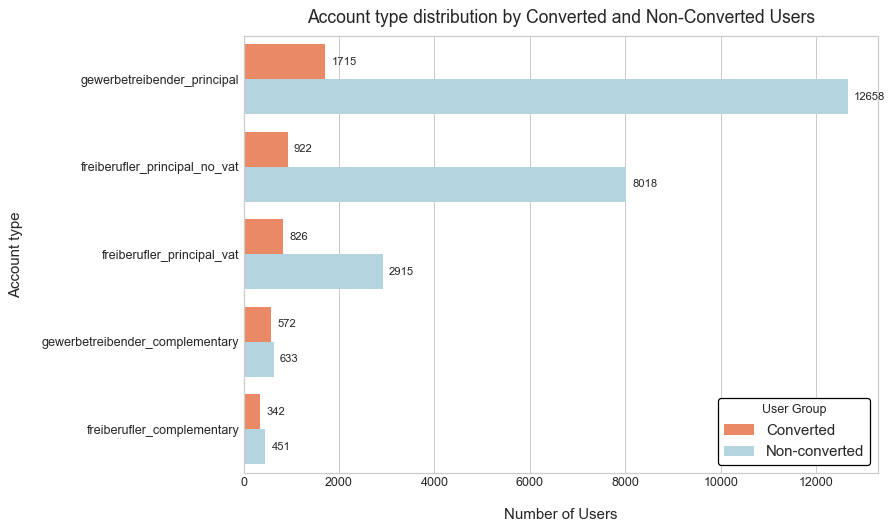

In [106]:
# Generate Account type counts for Converted and Non-Converted users
account_counts = pd.DataFrame({
    'Converted': converted_users['accounttype'].value_counts(),
    'Non-converted': non_converted_users['accounttype'].value_counts()
}).fillna(0)

# Convert counts to integers
account_counts['Converted'] = account_counts['Converted'].astype(int)
account_counts['Non-converted'] = account_counts['Non-converted'].astype(int)

# Prepare data for plotting without resetting index
account_table_plot = account_counts.melt(ignore_index=False, var_name='User Group', value_name='Count')
account_table_plot.index.name = 'VAT Type'
account_table_plot = account_table_plot.reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Count', y='VAT Type', hue='User Group', data=account_table_plot, palette=['coral', 'lightblue'])

# Add titles and labels
plt.title('Account type distribution by Converted and Non-Converted Users', fontsize=14, pad=10)
plt.xlabel('Number of Users', fontsize=12, labelpad=15)
plt.ylabel('Account type', fontsize=12, labelpad=15)
plt.legend(title='User Group', frameon=True, facecolor='white', edgecolor='black', fontsize=12, framealpha=1)

for container in ax.containers:
    ax.bar_label(container, labels=[f'{int(v)}' for v in container.datavalues], padding=5, fontsize=9)

plt.tight_layout()
plt.show()